# Black-Box Optimization Benchmarking [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/bbobax/blob/main/notebooks/bbob.ipynb)

In this notebook, we will simply visualize the 24 BBOB functions.

## Install

You will need Python 3.11 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install bbobax from PyPi:

In [ ]:
%pip install -U "bbobax[notebooks]"

## Import

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from bbobax import BBOB
from bbobax.fitness_fns import bbob_fns

In [3]:
seed = 0

key = jax.random.key(seed)

## Visualize BBOB functions

In [ ]:
def visualize_3d(bbob, params, state, key, ax=None, logscale=False, title=None):
    """Visualize optimization problem in 3D."""
    x = jnp.linspace(bbob.x_range[0], bbob.x_range[1], 100)
    y = jnp.linspace(bbob.x_range[0], bbob.x_range[1], 100)
    X, Y = jnp.meshgrid(x, y)

    # Convert to JAX arrays and reshape for evaluation
    grid = jnp.stack([X.flatten(), Y.flatten()], axis=-1)

    # Evaluate the function at each point
    def eval_fn(x_input):
        # evaluate returns (new_state, eval_result)
        _, res = bbob.evaluate(key, x_input, state, params)
        return res.fitness

    values = jax.vmap(eval_fn)(grid)
    Z = jnp.array(values).reshape(X.shape)

    if logscale:
        # Shift to avoid log(negative) or log(0)
        Z = Z - jnp.min(Z) + 1.0
        Z = jnp.log(Z)

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5), subplot_kw={"projection": "3d"})
        created_fig = True
    else:
        fig = ax.figure
        created_fig = False

    # Plot the surface with viridis colormap (reversed so small values are yellow)
    ax.plot_surface(X, Y, Z, cmap="viridis_r", antialiased=True, alpha=0.8)

    # Set labels and title
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    if title:
        ax.set_title(title)

    # Set the axis limits to match x_range
    ax.set_xlim(bbob.x_range[0], bbob.x_range[1])
    ax.set_ylim(bbob.x_range[0], bbob.x_range[1])

    # Use scientific notation for z-axis
    ax.ticklabel_format(axis="z", style="sci", scilimits=(0, 0))

    if created_fig:
        plt.tight_layout()
        plt.close()

    return fig

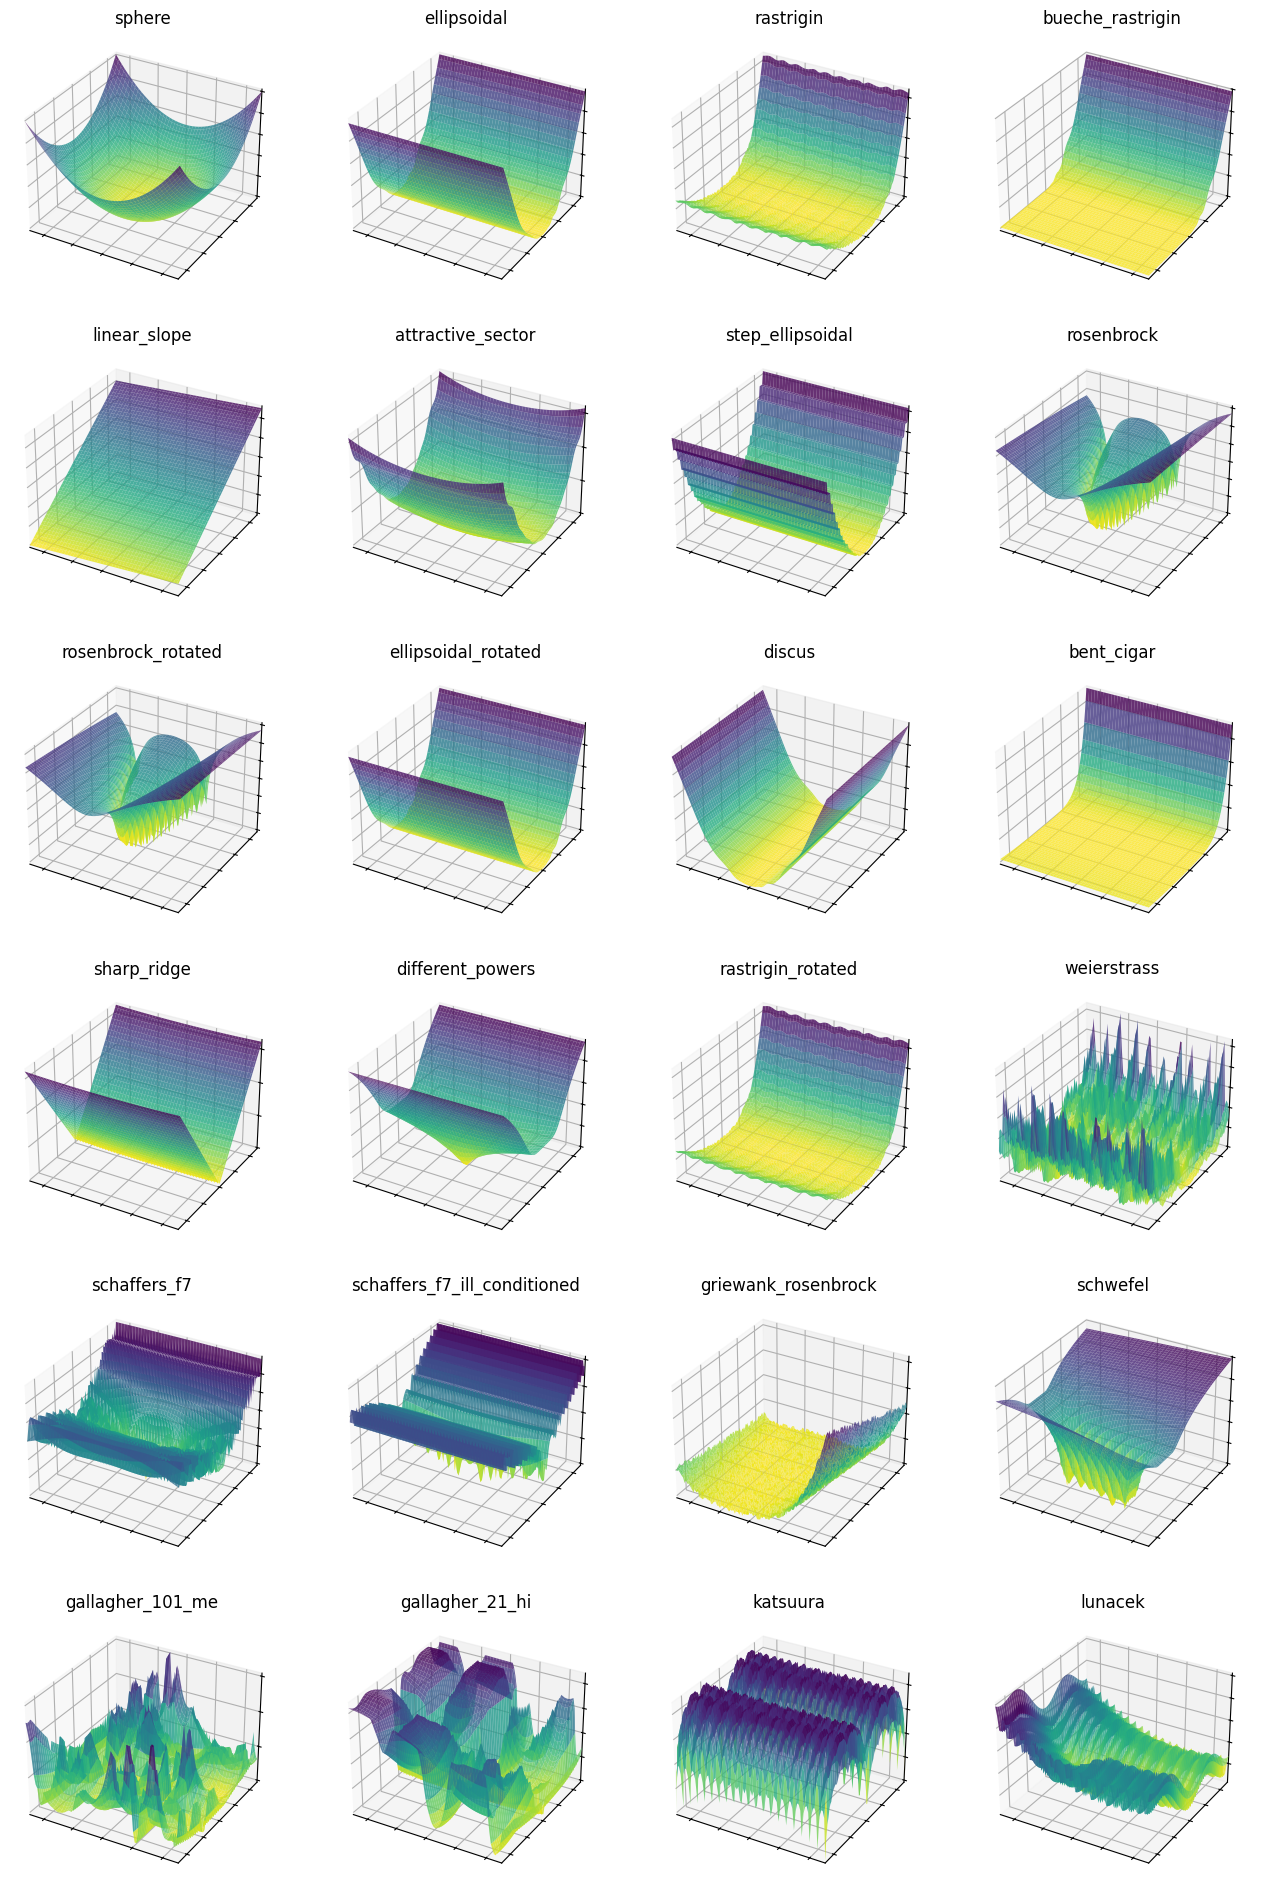

In [9]:
num_dims = 2

# Instantiates all BBOB problems
problems = {}
for name, fn in bbob_fns.items():
    problems[name] = BBOB(
        fitness_fns=[fn],
        min_num_dims=num_dims,
        max_num_dims=num_dims,
        x_opt_range=[0.0, 0.0],
        f_opt_range=[0.0, 0.0],
        sample_rotation=False,
        noise_config={"noise_model_names": ["noiseless"]},
    )

# List of functions to use logscale for
logscale_functions = [
    "rosenbrock",
    "rosenbrock_rotated",
    "different_powers",
    "schaffers_f7",
    "schaffers_f7_ill_conditioned",
    "schwefel",
    "katsuura",
]

# Create a figure with 6 rows and 4 columns
# 24 plots for ~24 functions
fig, axes = plt.subplots(6, 4, figsize=(16, 24), subplot_kw={"projection": "3d"})
axes = axes.flatten()

# Loop through all BBOB functions
for i, (fn_name, problem) in enumerate(problems.items()):
    if i >= len(axes):
        break

    # Sample params and state for this problem instance
    key, subkey = jax.random.split(key)
    params = problem.sample(subkey)
    state = problem.init(subkey, params)

    # Plot the function on the corresponding axis
    visualize_3d(
        problem,
        params,
        state,
        subkey,
        ax=axes[i],
        logscale=fn_name in logscale_functions,
        title=fn_name,
    )

    # Remove some elements to make the grid cleaner
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_zlabel("")
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].set_zticklabels([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()